In [1]:
## If you do not have the necessary libraries installed, run this cell (only for once)
# Be patient! It takes a few minutes.
## If you are running this notebook locally, to install standard libraries such as numpy, scipy, scikit-learn
# I recommend to use the package manager "conda". e.g.,  "conda install scikit-learn"
#!pip install ripser umap-learn kmapper persim PersistenceImages
#!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim
#!pip install tomaster Boruta

In [1]:
import numpy as np
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames, default_sphere, get_sphere
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model
from dipy.segment.mask import median_otsu
import dipy.reconst.dti as dti
from bids.layout import BIDSLayout
import nibabel as nib
from scipy import ndimage  # To rotate image for visualization purposes
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
import scipy as sp
import pandas as pd
import glob,os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
import persim
import gudhi
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
import cripser
import cv2


In [2]:
gradient_layout = BIDSLayout("/home/imane/Documents/openneuro/ds001907/sub-RC4201/ses-1/", validate=False)

subj = 'RC4201'

dwi_fname = gradient_layout.get(subject=subj, suffix='dwi', extension='.nii.gz', return_type='file')[0]
bvec_fname = gradient_layout.get( extension='.bvec', return_type='file')[0]
bval_fname = gradient_layout.get( extension='.bval', return_type='file')[0]

dwi_img = nib.load(dwi_fname)
affine = dwi_img.affine

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)

t1_fname = '/home/imane/Documents/openneuro/ds001907/sub-RC4201/ses-1/anat/sub-RC4201_ses-1_T1w.nii.gz'
t1_data = load_nifti_data(t1_fname)
dwi_data = dwi_img.get_fdata()

maskdata, mask = median_otsu(dwi_data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)
print('data.shape (%d, %d, %d, %d)' % dwi_data.shape)
csamodel = CsaOdfModel(gtab, 4)
sphere = get_sphere('repulsion724')
csapeaks = peaks_from_model(model=csamodel,
                            data=maskdata,
                            sphere=sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=mask,
                            return_odf=True,
                            normalize_peaks=True)

GFA = csapeaks.gfa

print('GFA.shape (%d, %d, %d)' % GFA.shape)

maskdata.shape (81, 108, 69, 129)
data.shape (128, 128, 72, 129)
GFA.shape (81, 108, 69)


In [3]:
GFA_coronale = ndimage.rotate(GFA[:, GFA.shape[1]//2, :],90, reshape=True)
GFA_axiale = ndimage.rotate(GFA[:, :, GFA.shape[-1]//2], 90, reshape=True)
GFA_sagittale = ndimage.rotate(GFA[GFA.shape[0]//2, :, :],90, reshape=True)

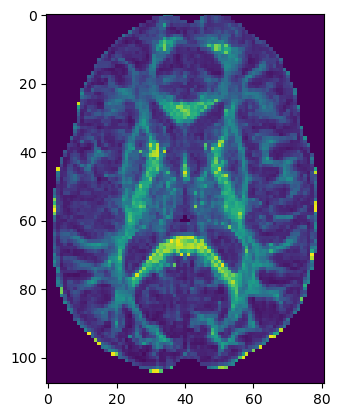

In [6]:
plt.imshow(GFA_axiale)

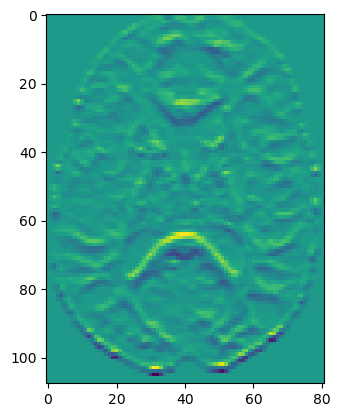

In [7]:
plt.imshow(ndimage.sobel(GFA_axiale,axis=0))#to apply sobel filter could choose axis=1 too

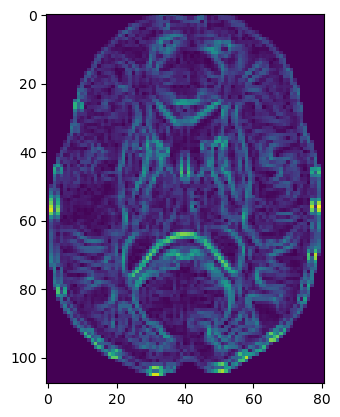

In [8]:
edges0=ndimage.sobel(GFA_axiale,axis=0)
edges1=ndimage.sobel(GFA_axiale,axis=1)
edges=np.sqrt(np.square(edges0)+np.square(edges1))
plt.imshow(edges) #can do it gray with cmap='gray'

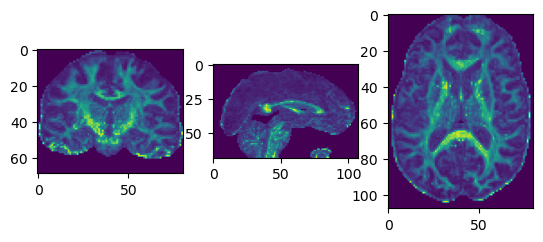

In [5]:
# Plot the GFA

%matplotlib inline

fig, ax = plt.subplots(1, 3)
ax[0].imshow(ndimage.rotate(GFA[:, GFA.shape[1]//2, :],90, reshape=True))
ax[1].imshow(ndimage.rotate(GFA[GFA.shape[0]//2, :, :],90, reshape=True))
ax[2].imshow(ndimage.rotate(GFA[:, :, GFA.shape[-1]//2], 90, reshape=True))

plt.show()

In [6]:
GFA_sagittale.shape
GFA.shape

(81, 108, 69)

In [18]:
GFA

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [7]:
data_small = maskdata[13:43, 44:74, 28:29]

from fury import window, actor

scene = window.Scene()

csaodfs = csamodel.fit(data_small).odf(sphere)
csaodfs = np.clip(csaodfs, 0, np.max(csaodfs, -1)[..., None])
csa_odfs_actor = actor.odf_slicer(csaodfs, sphere=sphere,
                                  scale=0.4)
csa_odfs_actor.display(z=0)

scene.add(csa_odfs_actor)

window.show(scene)

In [9]:
lut = actor.colormap_lookup_table(scale_range=(GFA.min(), GFA.max()*0.8),
                                  hue_range=(0.4, 1.),
                                  saturation_range=(1, 1.),
                                  value_range=(0., 1.))
GFA_actor = actor.slicer(GFA, affine, lookup_colormap=lut)

scene.clear()
scene.add(GFA_actor)

scene.reset_camera()
scene.zoom(1.4)
window.show(scene, size=(600, 600), reset_camera=False)


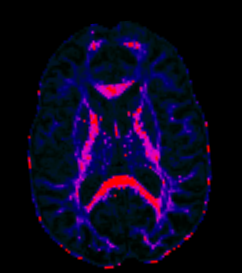

In [10]:
scene.clear()
slice_actor2 = GFA_actor.copy()

scene.add(slice_actor2)

slice_actor2.display(slice_actor2.shape[0]//2, None, None)
scene.zoom(1.4)
window.show(scene, size=(600, 600), reset_camera=False)

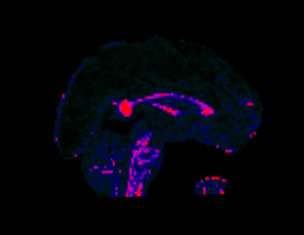


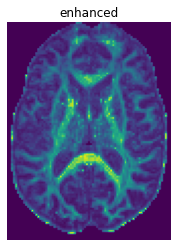

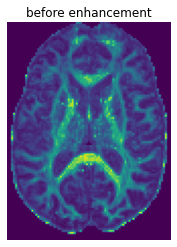

In [11]:
#to be reviewed after i don't see the difference between enhanced and not enhanced
def enhance_sharpness(image, strength):
    if len(image.shape) == 2:
        # Grayscale image
        gray_image = image
    else:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the unsharp mask filter
    sharpened_image = cv2.addWeighted(gray_image, 1 + strength, cv2.GaussianBlur(gray_image, (0, 0), strength), -strength, 0)

    # Convert the sharpened image back to RGB if necessary
    if len(image.shape) == 3:
        sharpened_image = cv2.cvtColor(sharpened_image, cv2.COLOR_GRAY2RGB)

    return sharpened_image

# Example usage
# Define the strength value for sharpness enhancement
strength = 100.0# Adjust this value to control the strength of the sharpness enhancement

# Enhance the sharpness of the image
sharpened_image = enhance_sharpness(GFA_axiale, strength)


# Display the sharpened image
plt.imshow(sharpened_image)
plt.axis('off')
plt.title('enhanced')
plt.show()

plt.imshow(GFA_axiale)
plt.axis('off')
plt.title('before enhancement')
plt.show()


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

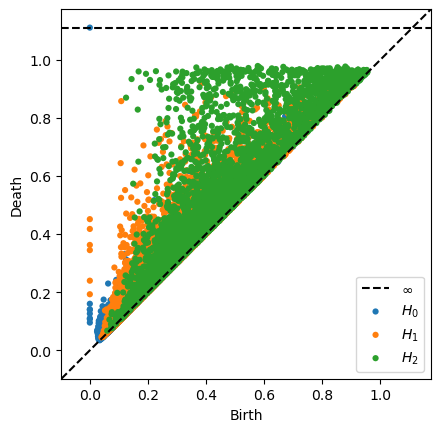

In [9]:
## compute persistence of the sublevel filtration of the volumetric image
pd = cripser.computePH(GFA,maxdim=2,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
diags = [p[:,1:3] for p in pds]
persim.plot_diagrams(diags)

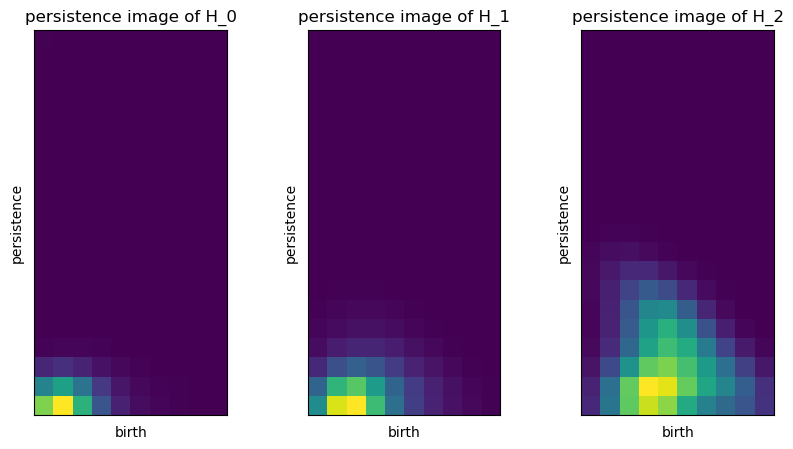

In [10]:
#Transforming H0,H1and H2 To persistance images 

min_birth, max_death = 0,2
dclip = [np.clip(d,min_birth, max_death) for d in diags]
pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
pimgr.fit(dclip, skew=True)
pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

plt.figure(figsize=(10,5))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    pimgr.plot_image(pimgs[i], ax)
    plt.title("persistence image of H_{}".format(i))


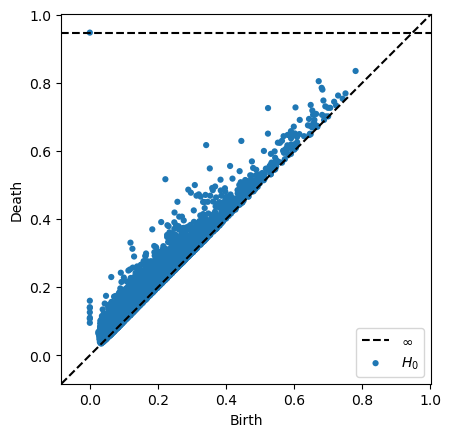

In [18]:
#Visualizing h0 ONLY
pd = cripser.computePH(GFA,maxdim=2,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
diags = [p[:,1:3] for p in pds]
persim.plot_diagrams(pd[pd[:,0]==0,1:3])


In [19]:
listsick = [
 'sub-RC4206',
 'sub-RC4215',
 'sub-RC4210',
 'sub-RC4213',
 'sub-RC4224',
 'sub-RC4219',
 'sub-RC4220',
 'sub-RC4226',
 'sub-RC4218',
 'sub-RC4225',
 'sub-RC4211',
 'sub-RC4221',
 'sub-RC4208',
 'sub-RC4227',
 'sub-RC4204',
 'sub-RC4201',
 'sub-RC4217',
 'sub-RC4207',
 'sub-RC4212',
 'sub-RC4214']
listhealthy = ['sub-RC4116',
 'sub-RC4122',
 'sub-RC4114',
 'sub-RC4113',
 'sub-RC4129',
 'sub-RC4110',
 'sub-RC4115',
 'sub-RC4131',
 'sub-RC4120',
 'sub-RC4117',
 'sub-RC4125',
 'sub-RC4118',
 'sub-RC4121',
 'sub-RC4109',
 'sub-RC4119',
 'sub-RC4128',
 'sub-RC4130',
 'sub-RC4126',
 'sub-RC4111',
 'sub-RC4107',
 'sub-RC4101',
 'sub-RC4123',
 'sub-RC4112'
 ]

/home/imane/mambaforge/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


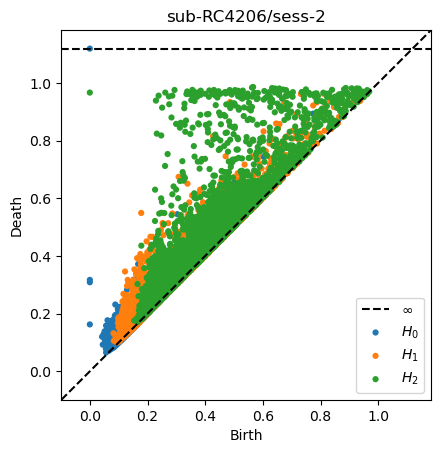

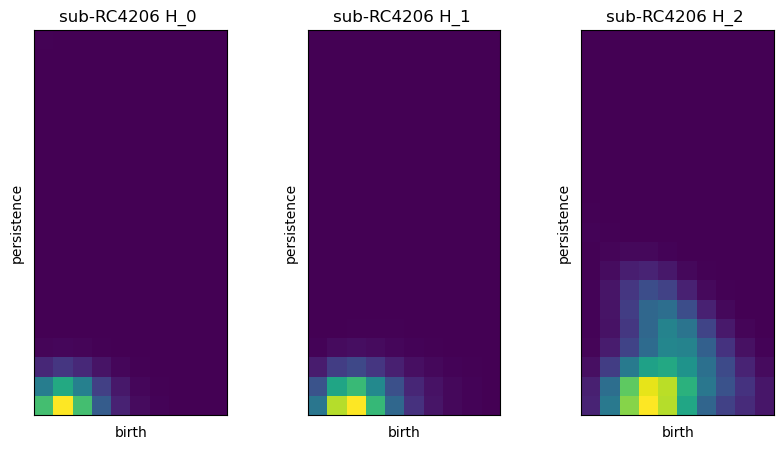

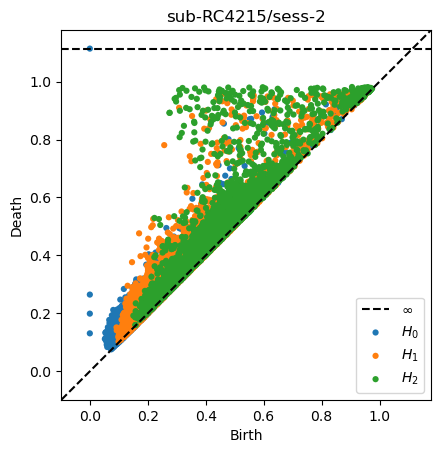

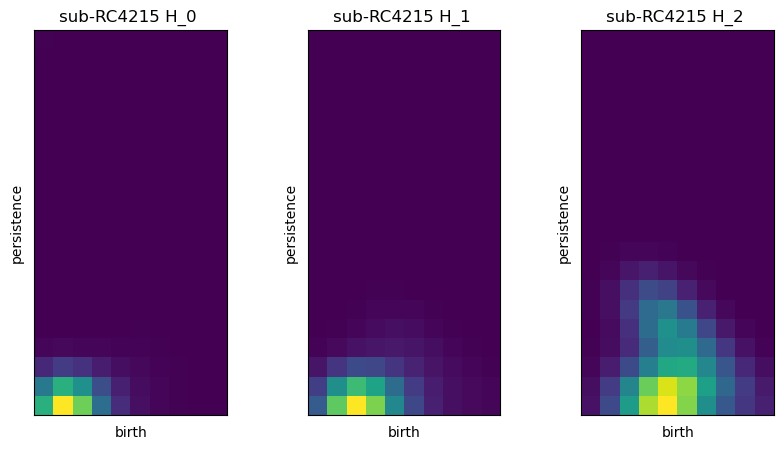

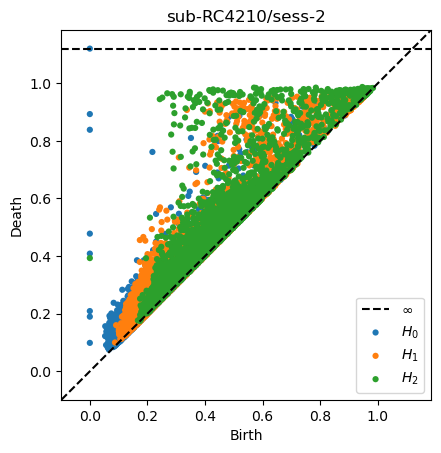

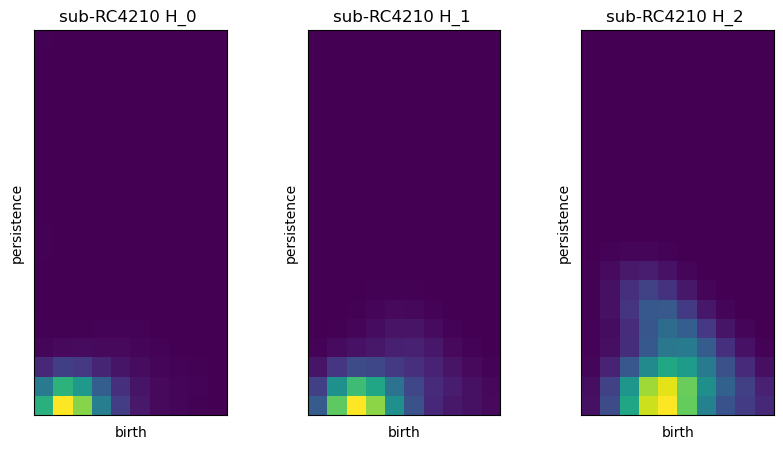

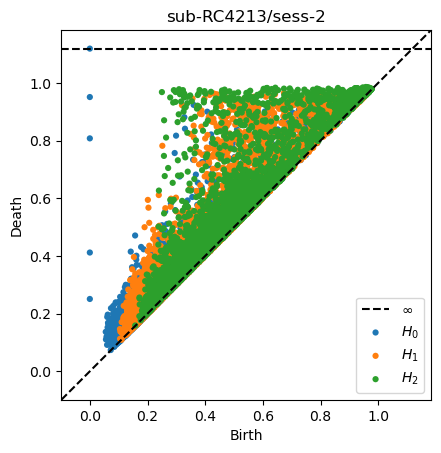

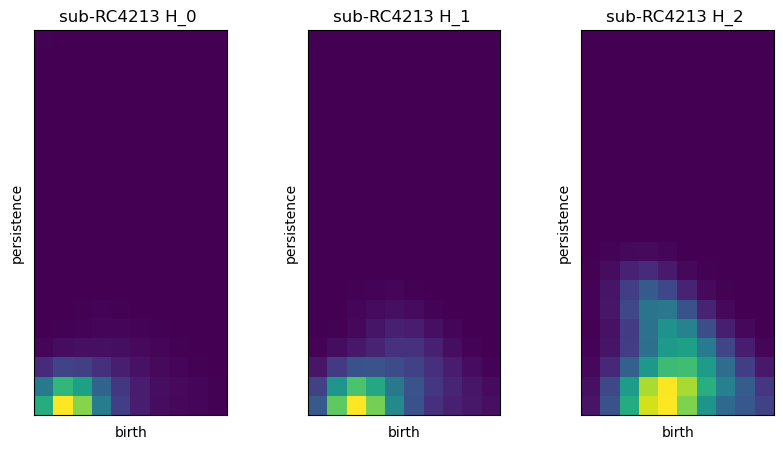

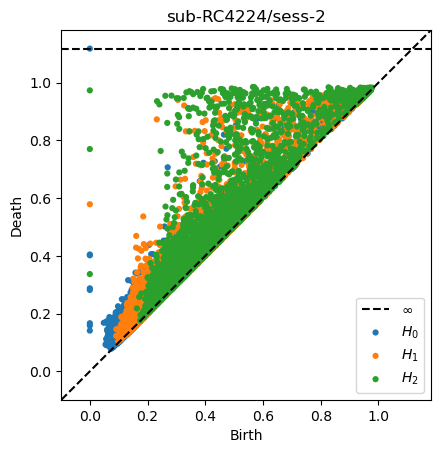

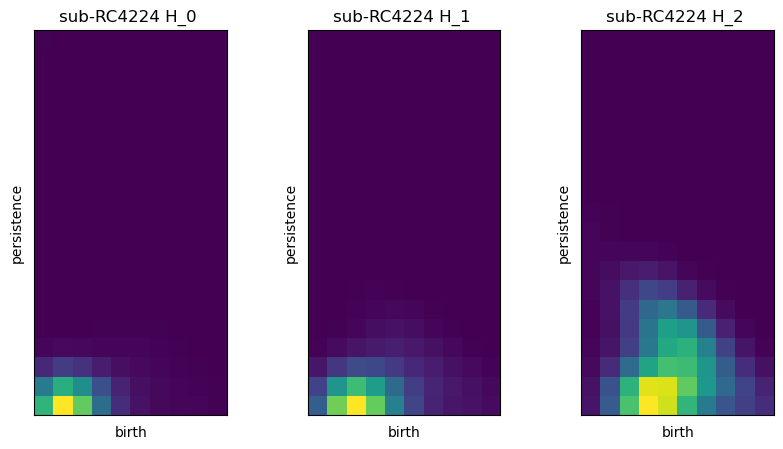

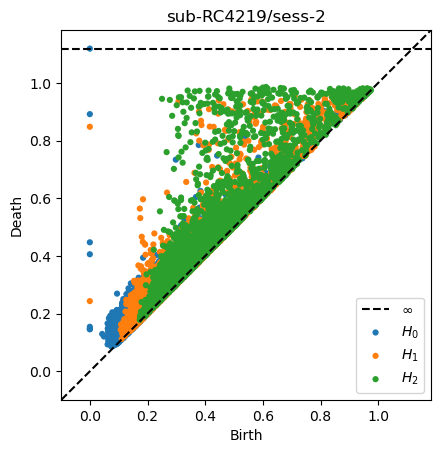

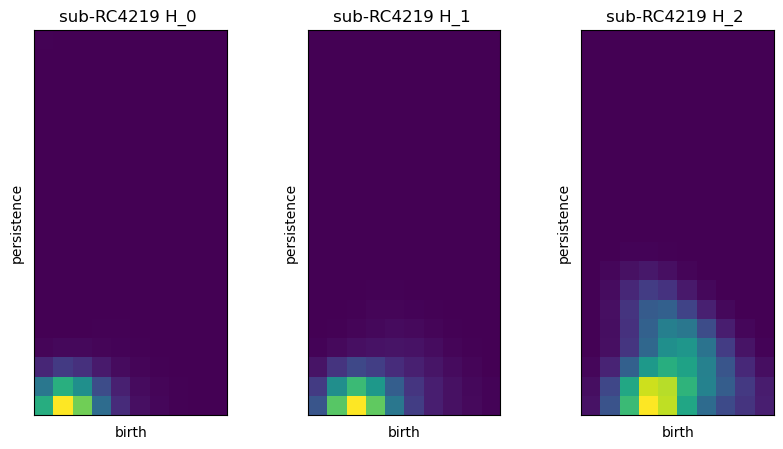

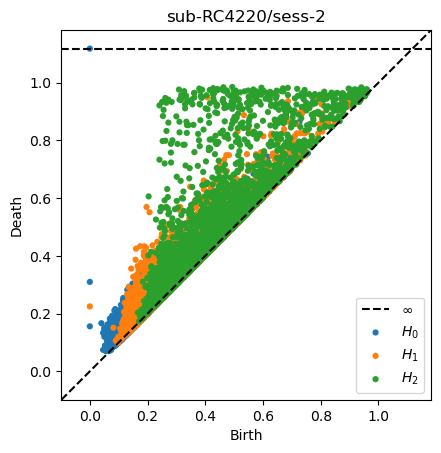

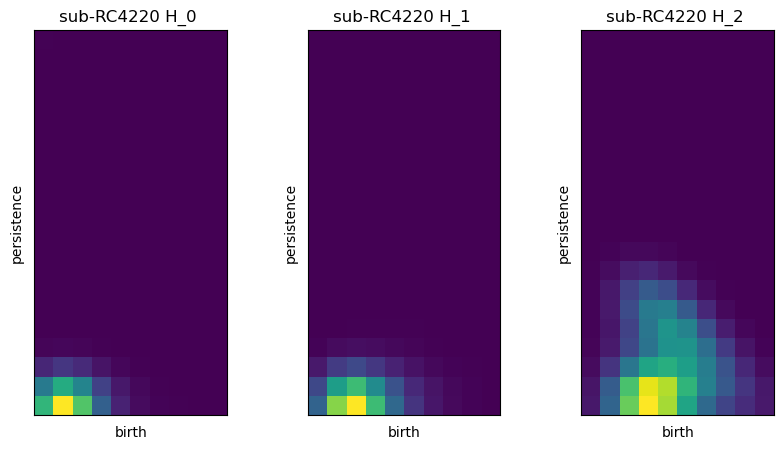

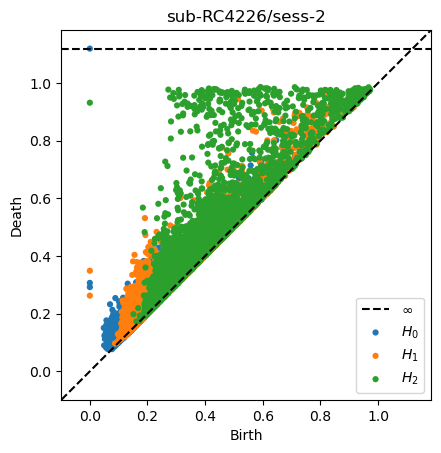

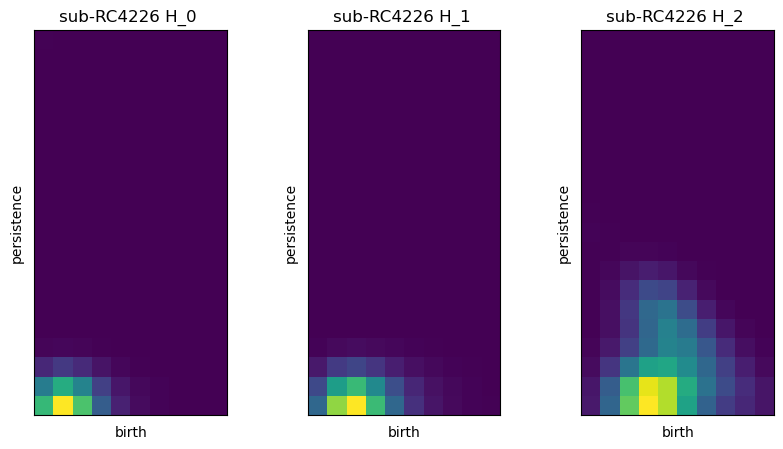

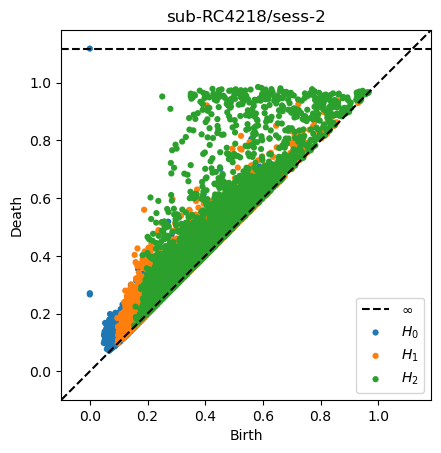

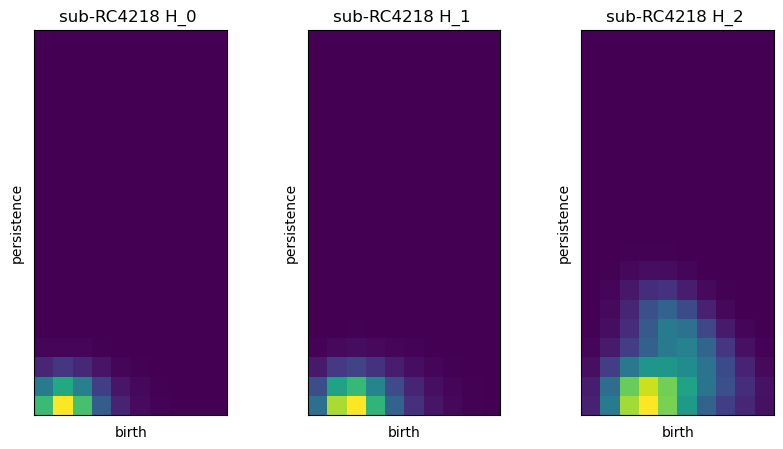

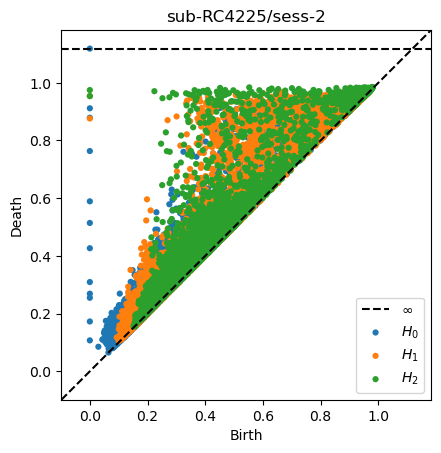

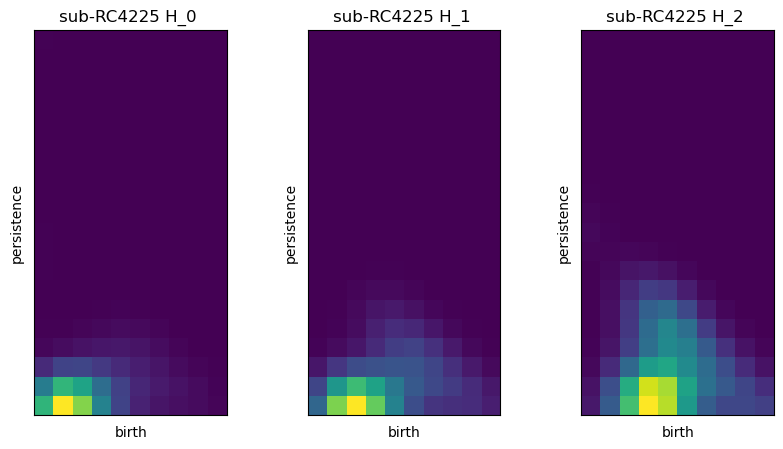

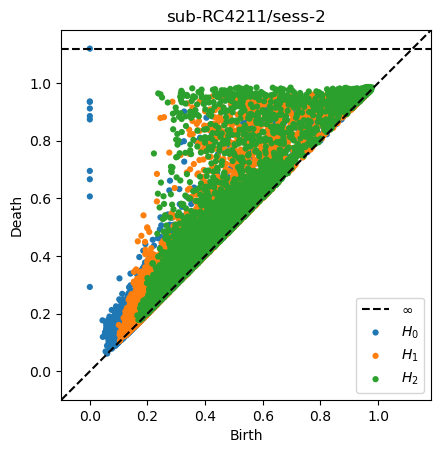

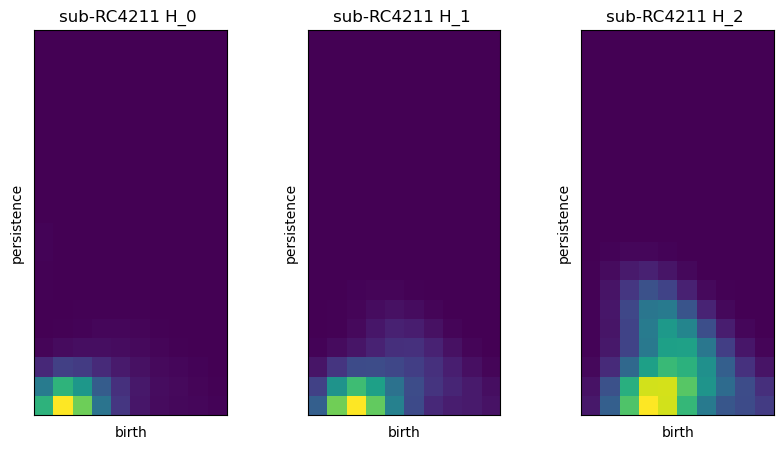

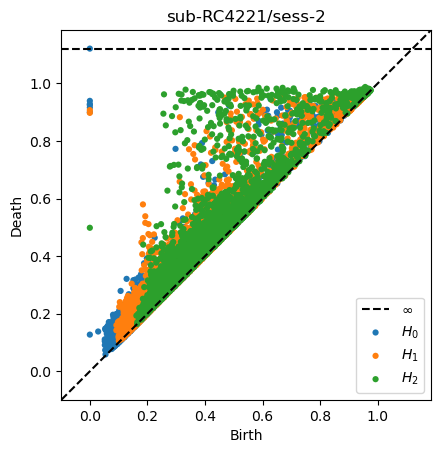

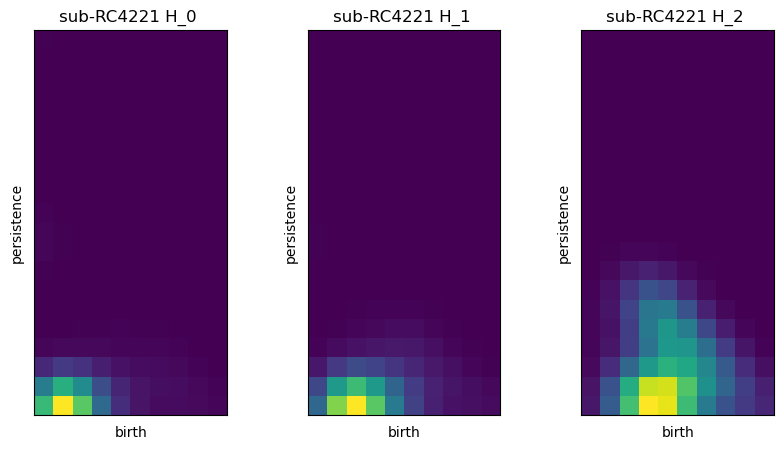

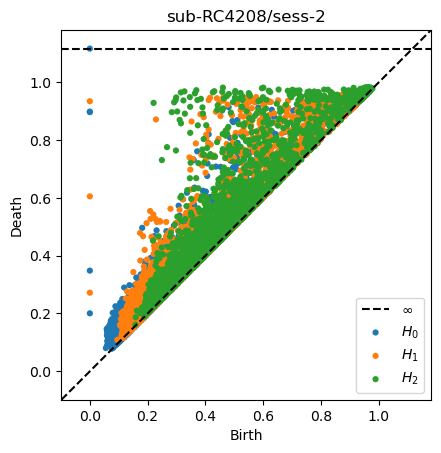

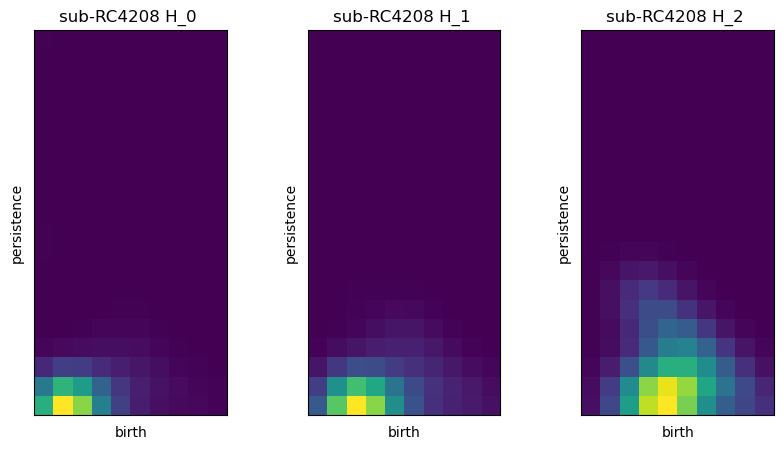

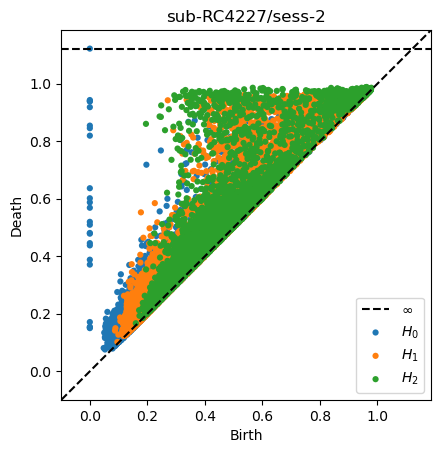

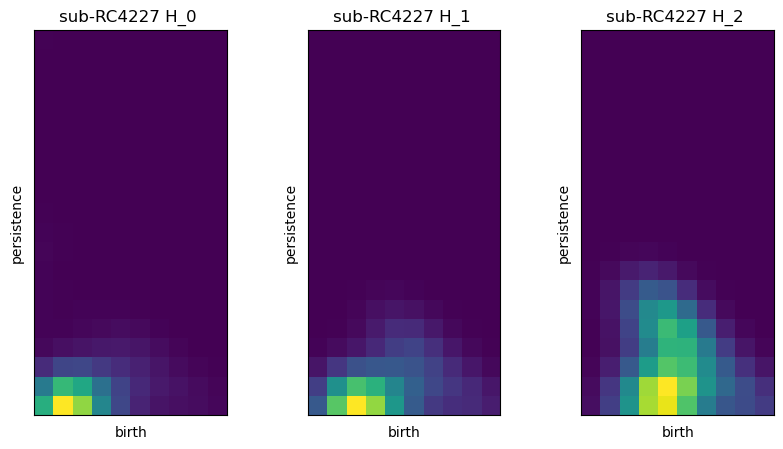

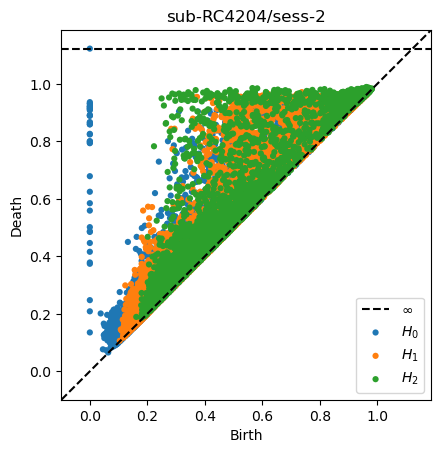

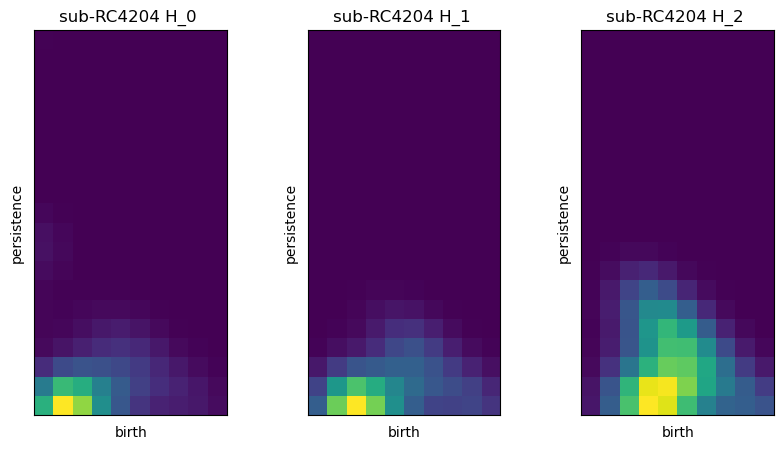

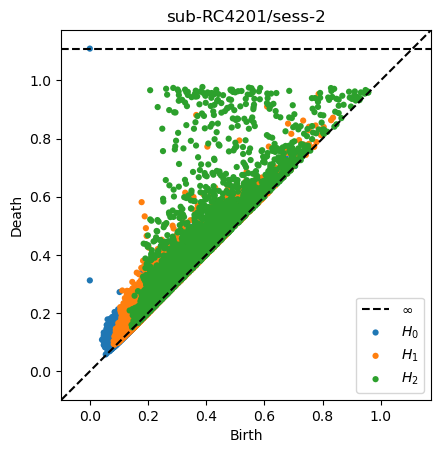

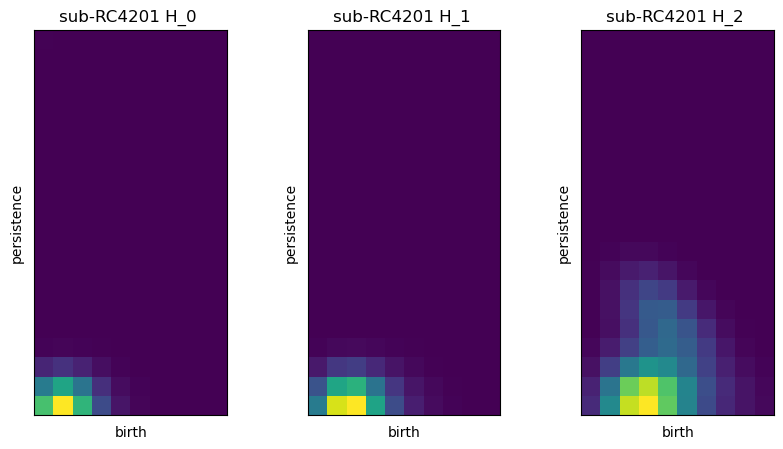

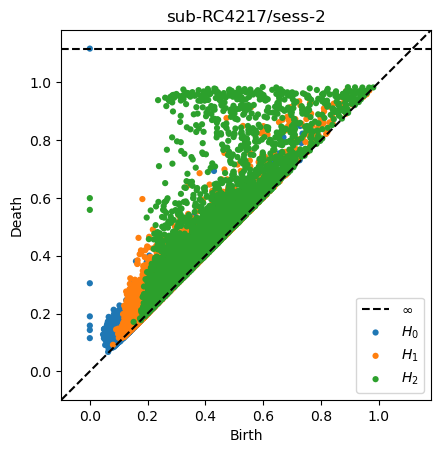

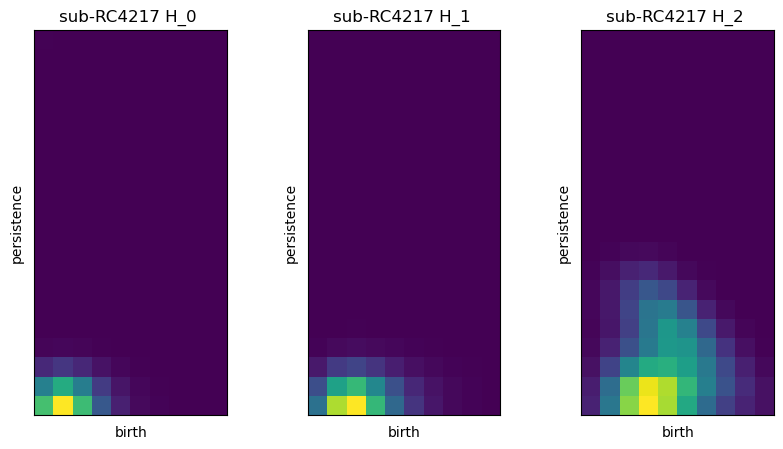

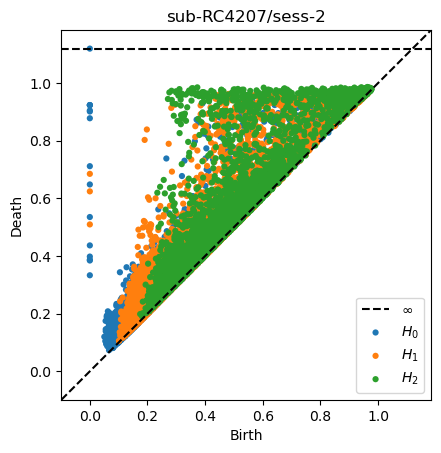

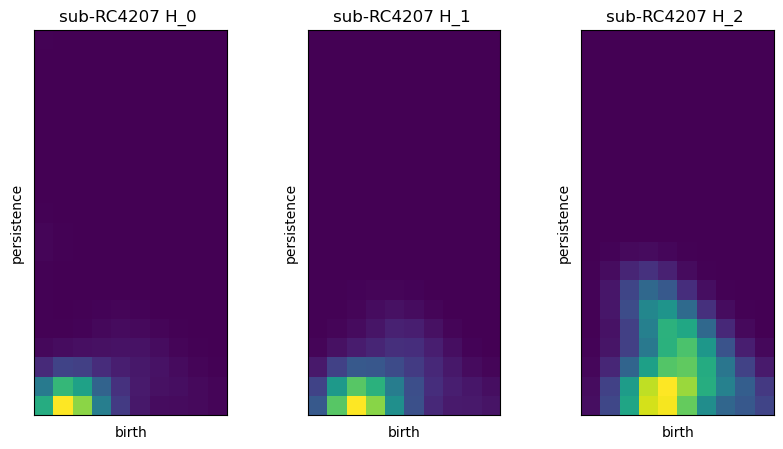

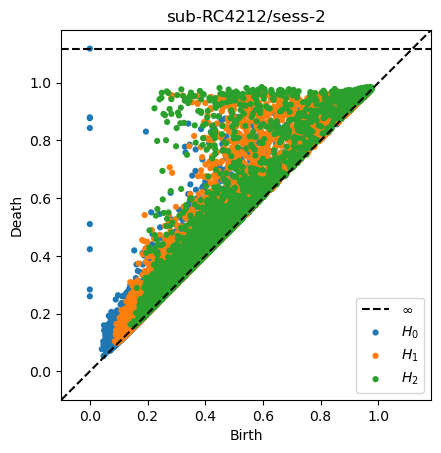

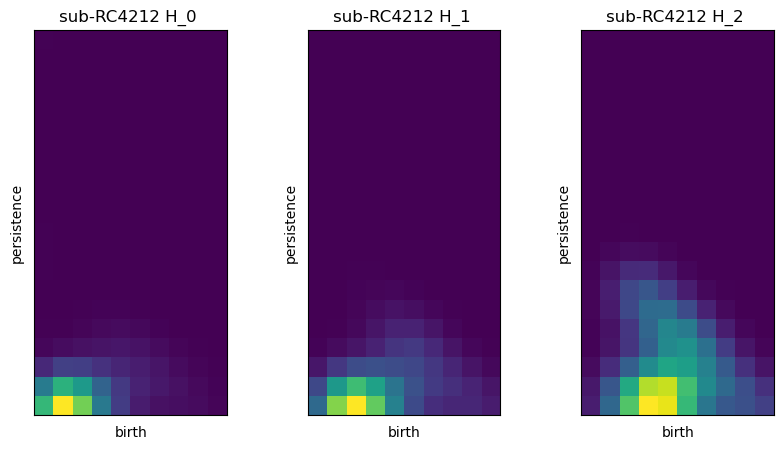

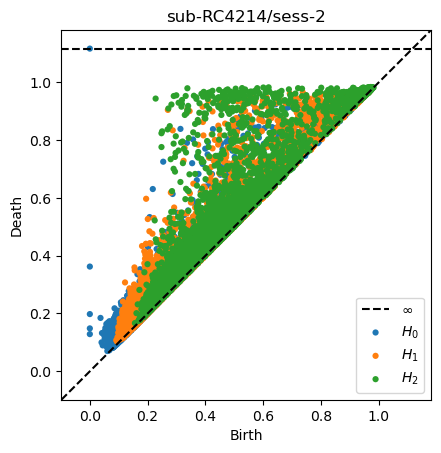

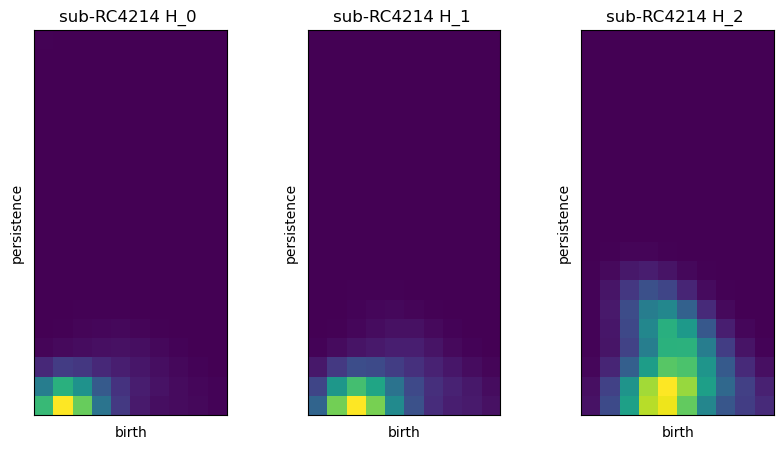

In [20]:
#GFA sick
import os 
import nibabel as nib
import numpy as np
from dipy.reconst.shm import CsaOdfModel
from dipy.data import get_fnames, default_sphere, get_sphere
# NEW
import matplotlib.pyplot as plt

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from dipy.direction import peaks_from_model
import cripser
import persim

dwi_fname = []
bvec_fname = []
bval_fname =[]
dwi_img=[]
affine =[]
sick_diagram_array =[]
sick_pimgs_array=[]
diagrams_H0_sick = []
diagrams_H1_sick = []
diagrams_H2_sick = []
pimgs_H0_sick = []
pimgs_H1_sick = []
pimgs_H2_sick = []
for subject in  listsick :
    subj = subject
    sess = '2'
    base_path = f"/home/imane/Documents/openneuro/ds001907/{subj}/ses-{sess}/dwi/"
    dwi_fname.append(base_path+f"{subj}_ses-{sess}_dwi.nii.gz")
    bvec_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bvec")
    bval_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bval")
    dwi_img.append(nib.load(dwi_fname[-1]))
    affine.append(dwi_img[-1].affine)
    bvals, bvecs = read_bvals_bvecs(bval_fname[-1], bvec_fname[-1])
    gtab = gradient_table(bvals, bvecs)
    dwi_data = dwi_img[-1].get_fdata()
    dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)  # Specify the volume index to the b0 volumes
    csamodel = CsaOdfModel(gtab, 4)
    csapeaks = peaks_from_model(model=csamodel,
                            data=dwi_data,
                            sphere=default_sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=dwi_mask,
                            return_odf=False,
                            normalize_peaks=True,
                            parallel=True)

    GFA = csapeaks.gfa
    pd = cripser.computePH(GFA,maxdim=2,location="birth")
    pds = [pd[pd[:,0] == i] for i in range(3)]
    

    figure, n_axis = plt.subplots()
    n_axis.set_title(subj+"/sess-"+sess)
    diags = [p[:,1:3] for p in pds]
    sick_diagram_array.append(diags)
    diagrams_H0_sick.append(sick_diagram_array[-1][0])
    diagrams_H1_sick.append(sick_diagram_array[-1][1])
    diagrams_H2_sick.append(sick_diagram_array[-1][2])
    
    persim.plot_diagrams(diags, ax=n_axis)
    #tranform pesistance diags to images for each patient
    min_birth, max_death = 0,2
    dclip = [np.clip(d,min_birth, max_death) for d in diags]
    pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
    pimgr.fit(dclip, skew=True)
    pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)
    sick_pimgs_array.append(pimgs)
    pimgs_H0_sick.append(pimgs[-1][0])
    pimgs_H1_sick.append(pimgs[-1][1])
    pimgs_H2_sick.append(pimgs[-1][2])

    plt.figure(figsize=(10,5))
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        pimgr.plot_image(pimgs[i], ax)
        plt.title(subj+" H_{} ".format(i))

In [61]:
sick_diagram_array

[[array([[5.64064849e-002, 6.52607603e-002],
         [6.66255487e-002, 7.16693006e-002],
         [7.41419252e-002, 7.71580259e-002],
         ...,
         [8.68145731e-001, 8.79129072e-001],
         [7.74487554e-001, 8.93579360e-001],
         [0.00000000e+000, 1.79769313e+308]]),
  array([[0.964176  , 0.96799021],
         [0.94717111, 0.95524208],
         [0.94376963, 0.95078777],
         ...,
         [0.08908634, 0.12005901],
         [0.08328943, 0.10604699],
         [0.08225923, 0.13174166]]),
  array([[0.96878085, 0.96973299],
         [0.96562501, 0.97293741],
         [0.96222453, 0.96286559],
         ...,
         [0.16288263, 0.18313539],
         [0.15379543, 0.17587576],
         [0.        , 0.9666318 ]])],
 [array([[7.38508004e-002, 7.57184526e-002],
         [7.83421869e-002, 7.92577946e-002],
         [7.08936800e-002, 7.95380859e-002],
         ...,
         [9.20689781e-001, 9.40537561e-001],
         [8.32939235e-001, 9.41131589e-001],
         [0.00000000e+

In [60]:
sick_pimgs_array

[[array([[ 3.20313729e+01,  1.94259367e+01,  5.01430218e+00,
           6.18386061e-01,  6.22942738e-02,  7.09898864e-03,
           4.62526941e-04,  1.23951618e-05,  1.28490469e-07,
           5.06894666e-10,  7.54737384e-13,  8.96253955e-16,
           9.27850242e-13,  7.14676043e-10,  2.07201570e-07,
           2.27641404e-05,  9.56144867e-04,  1.55221141e-02,
           9.85750437e-02,  2.47584351e-01],
         [ 4.56331209e+01,  2.77278058e+01,  7.19319284e+00,
           8.43263457e-01,  5.83926116e-02,  4.07600379e-03,
           2.25062032e-04,  5.80201322e-06,  5.94876181e-08,
           2.33764331e-10,  3.47520403e-13,  3.83013906e-16,
           4.26653465e-13,  3.28631587e-10,  9.52781084e-08,
           1.04677017e-05,  4.39666910e-04,  7.13757945e-03,
           4.53280527e-02,  1.13847441e-01],
         [ 3.19462290e+01,  1.97973866e+01,  5.32403869e+00,
           6.50741998e-01,  4.10557183e-02,  1.77828059e-03,
           6.14957079e-05,  1.26628610e-06,  1.17827831e

/home/imane/mambaforge/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


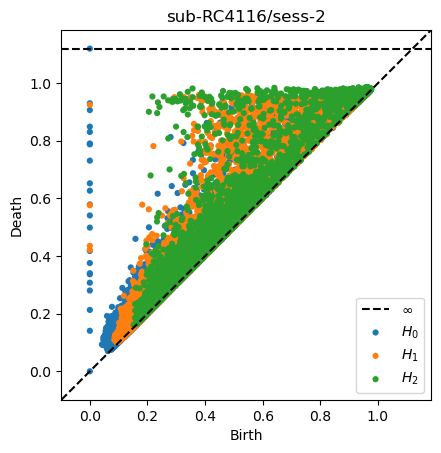

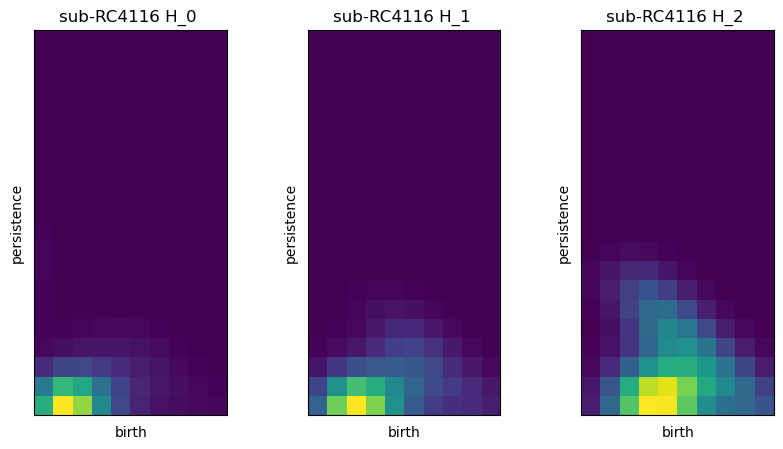

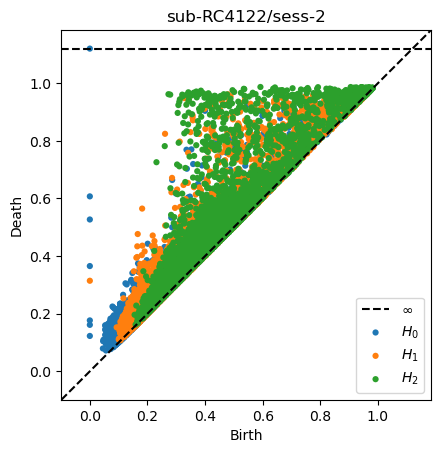

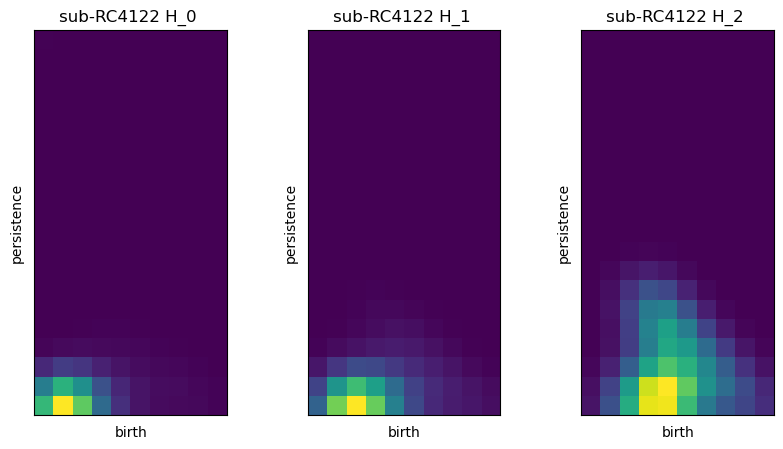

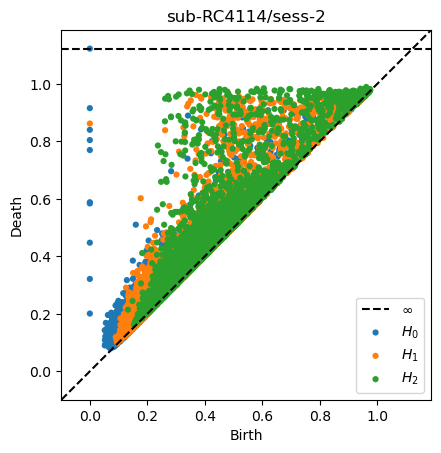

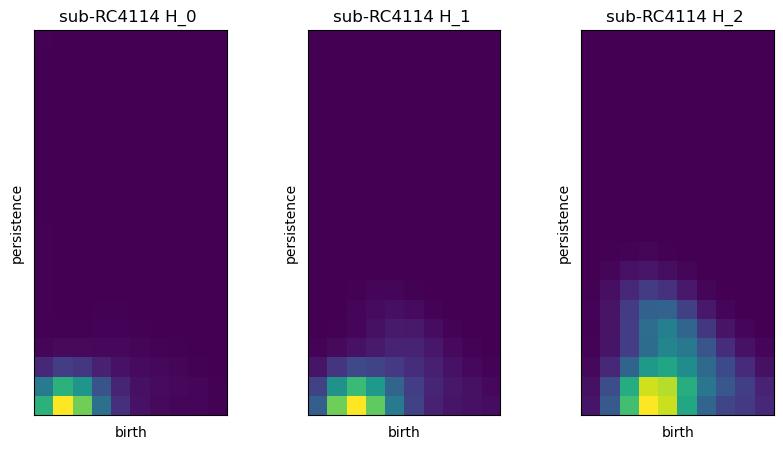

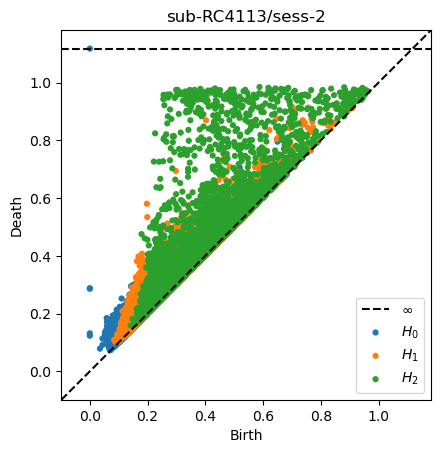

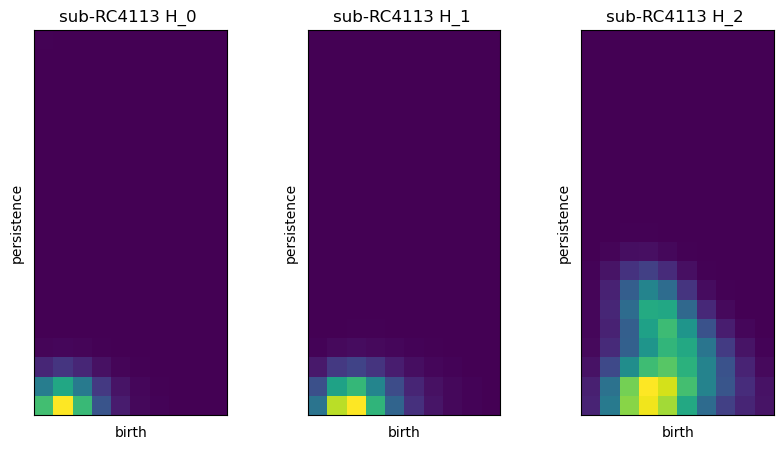

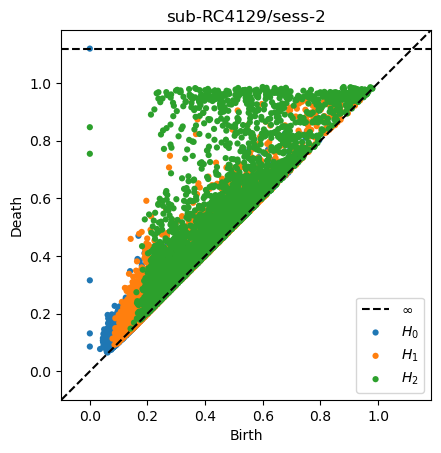

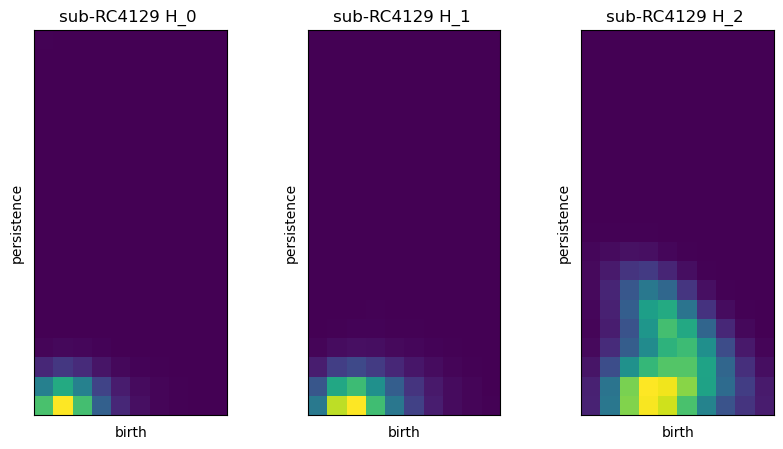

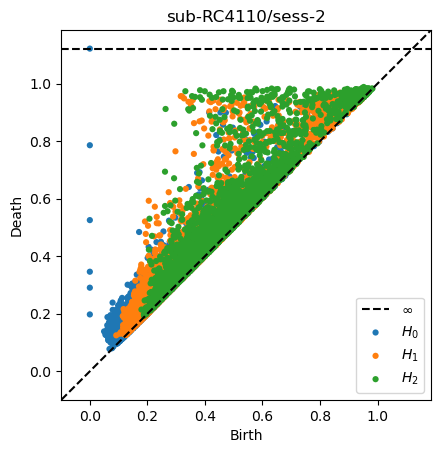

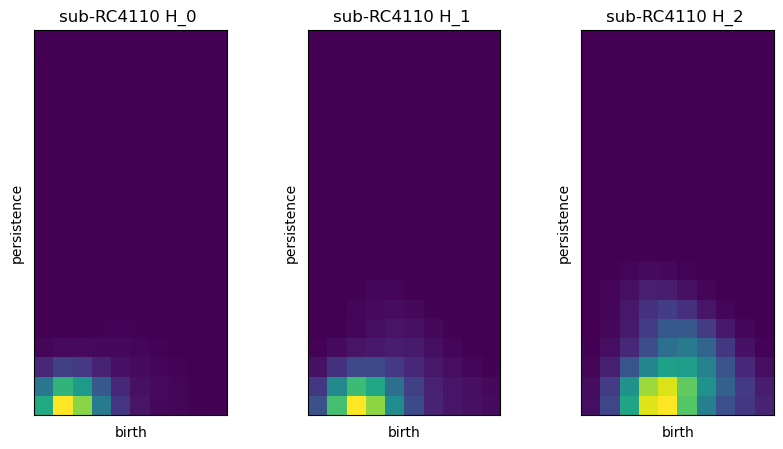

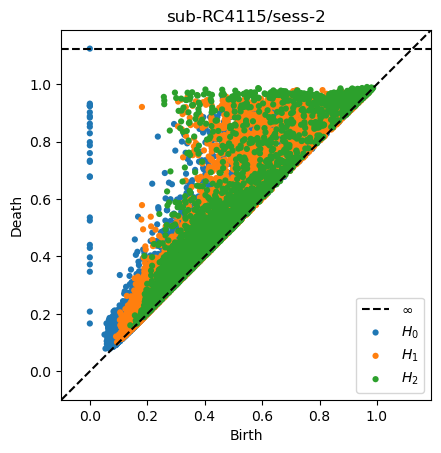

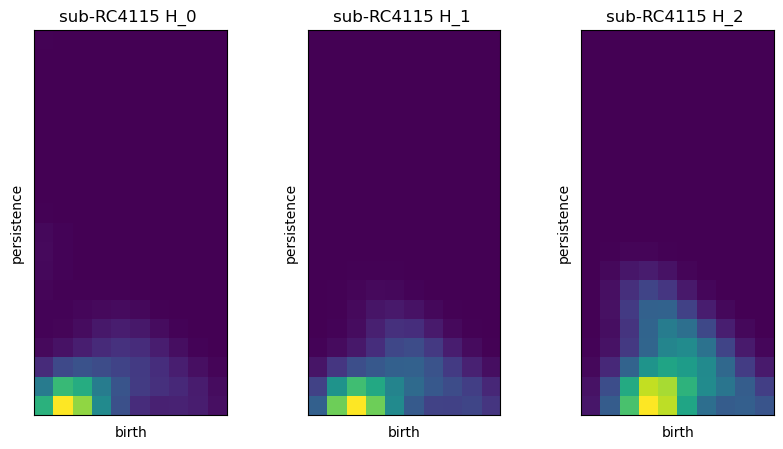

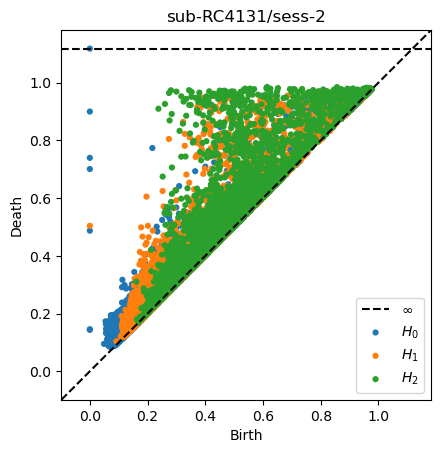

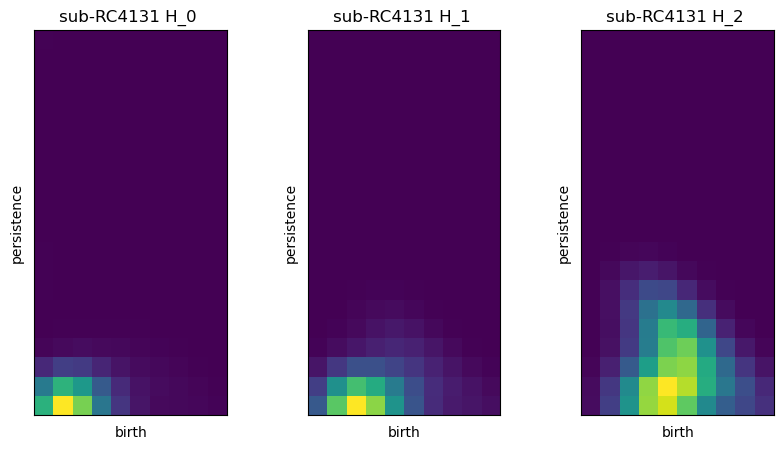

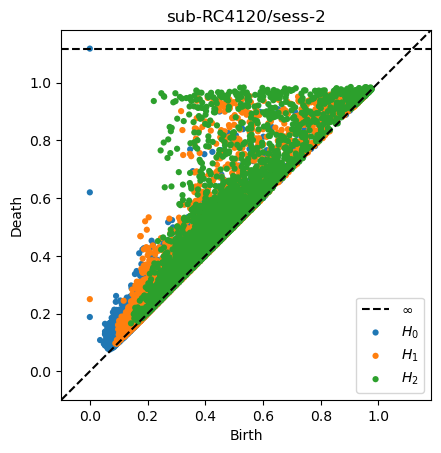

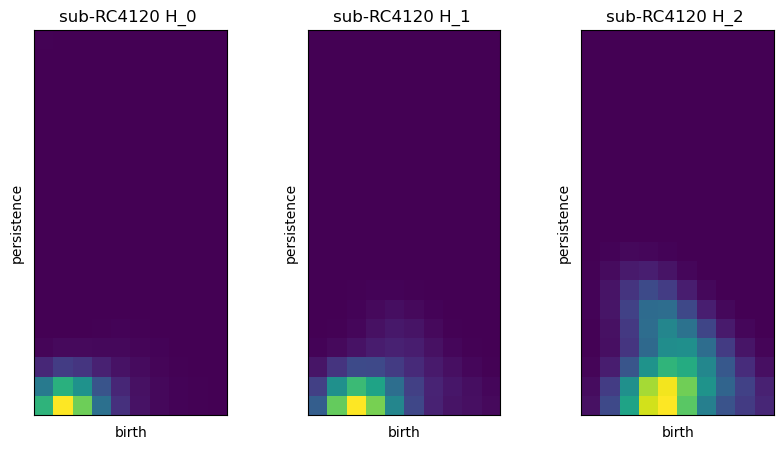

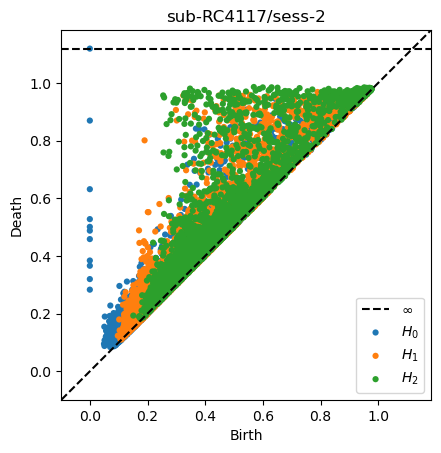

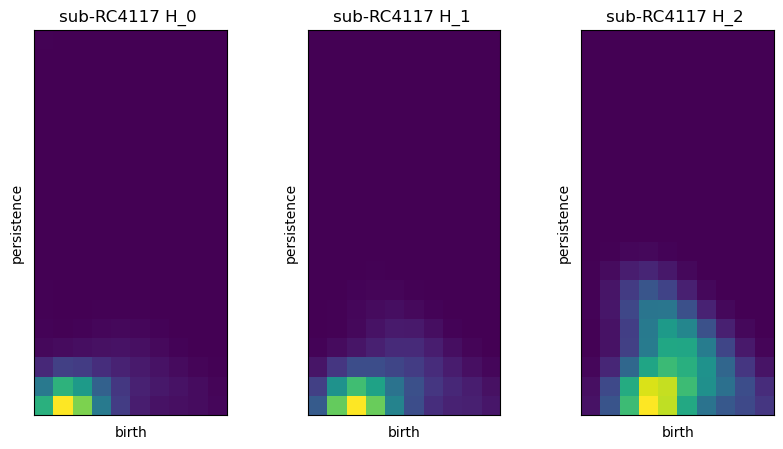

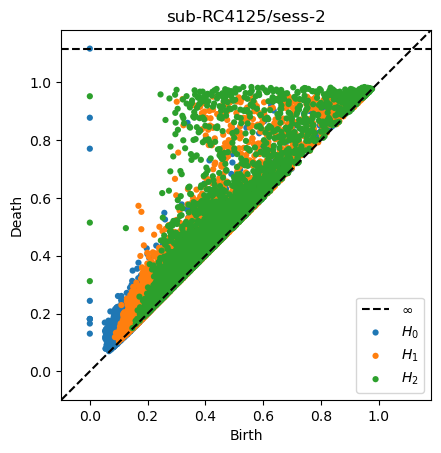

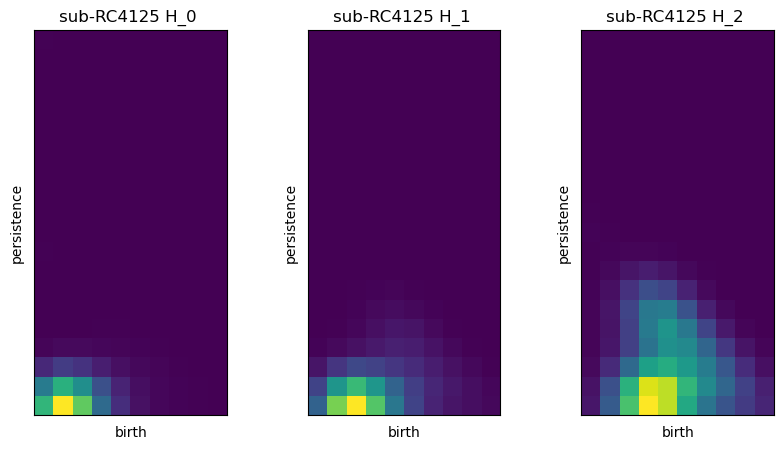

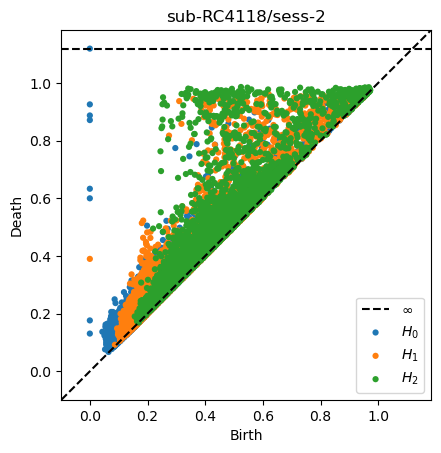

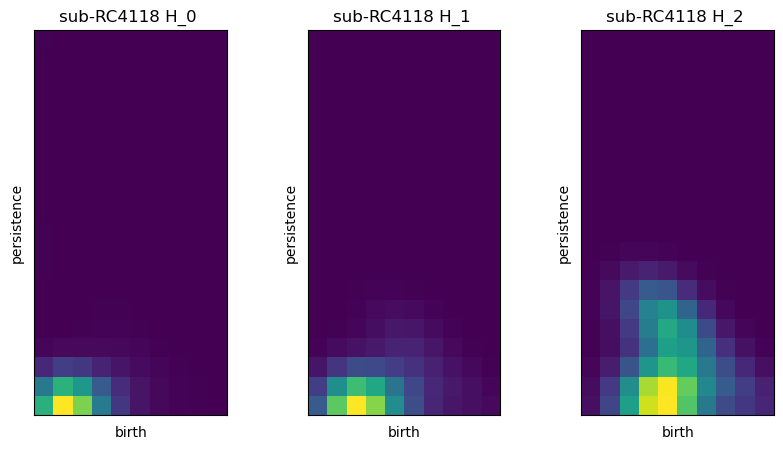

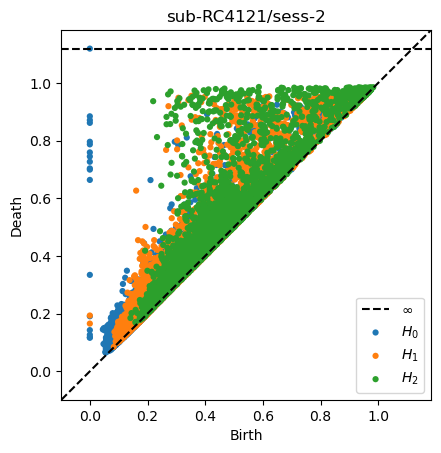

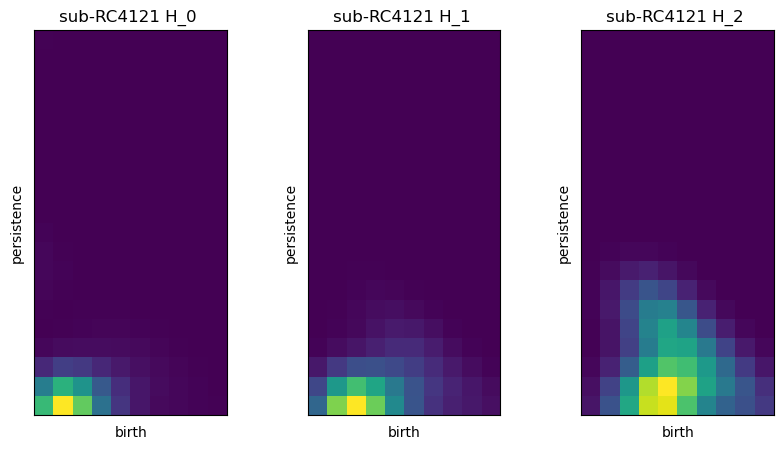

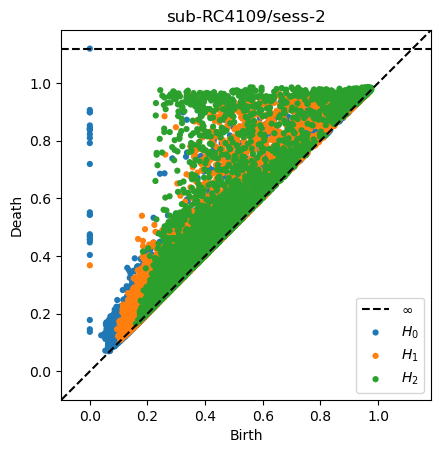

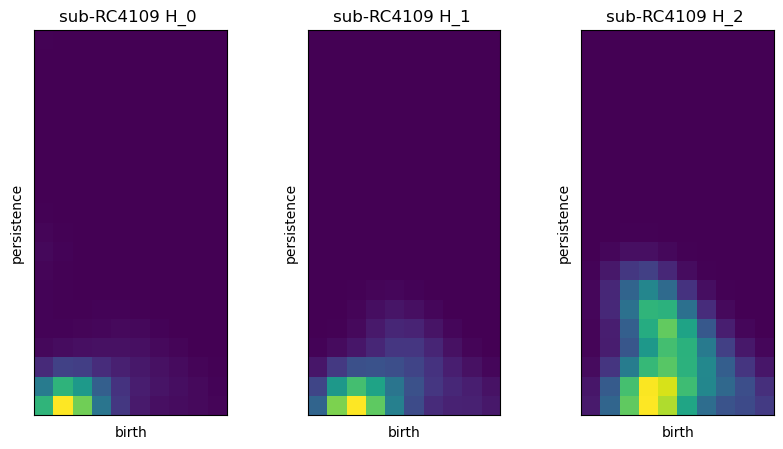

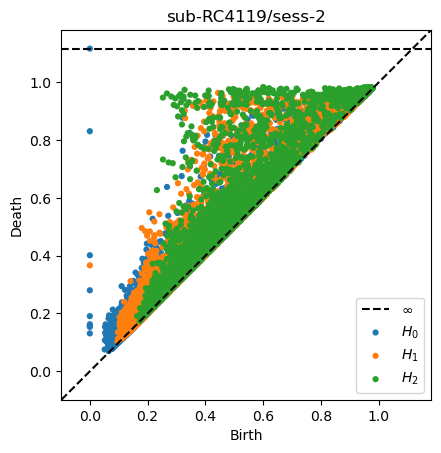

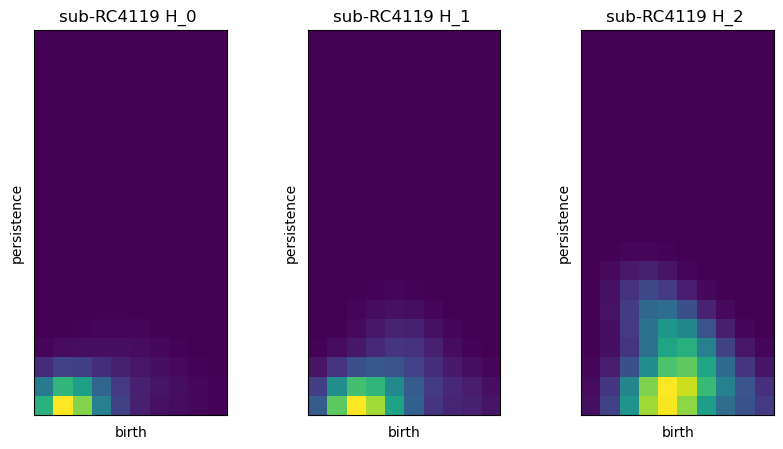

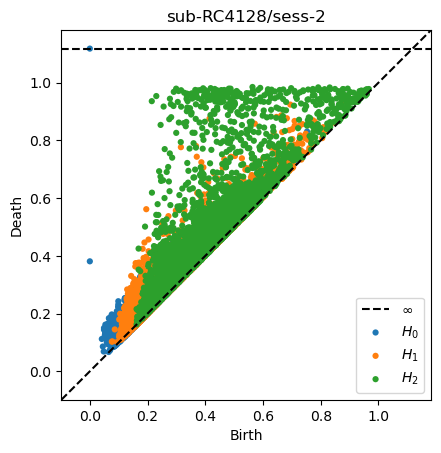

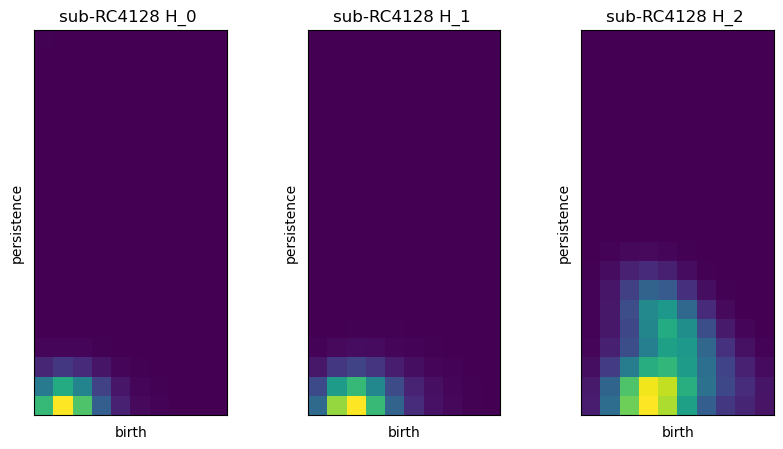

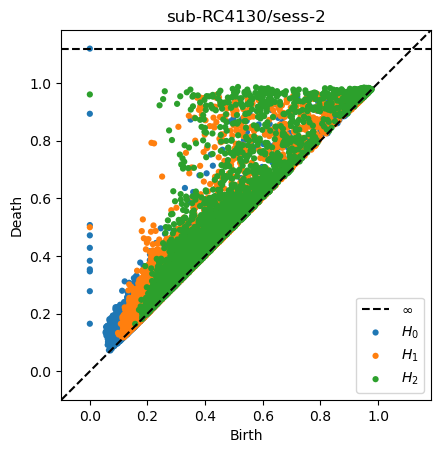

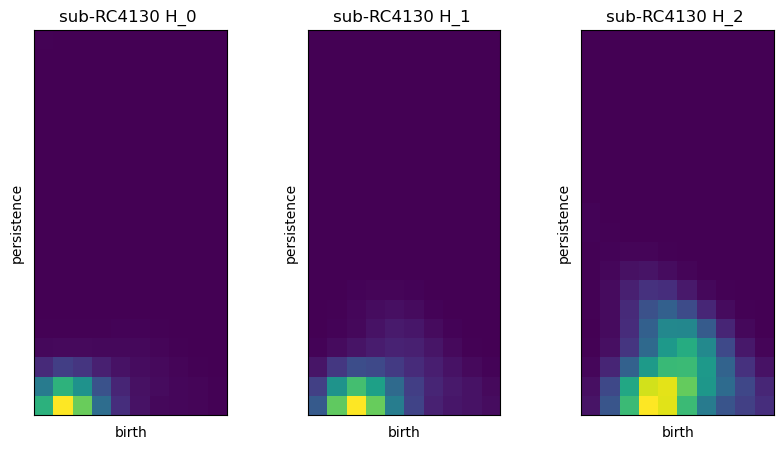

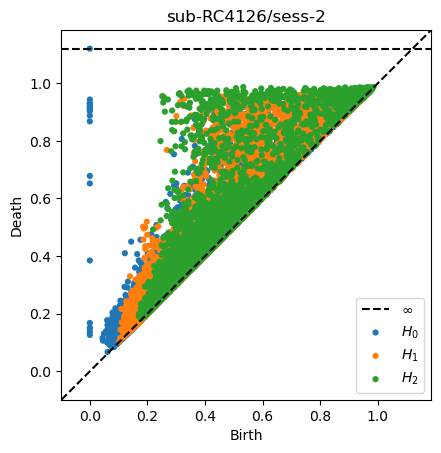

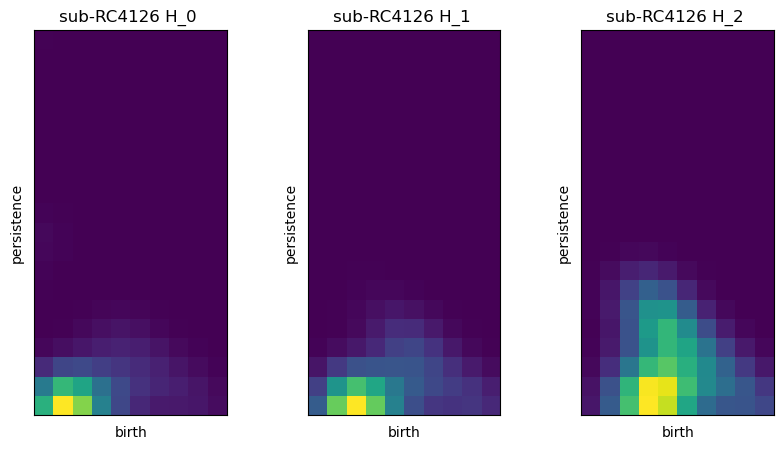

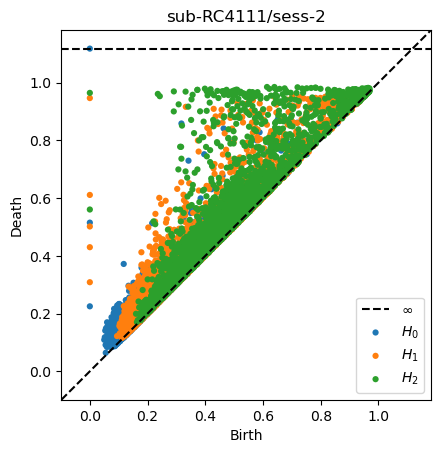

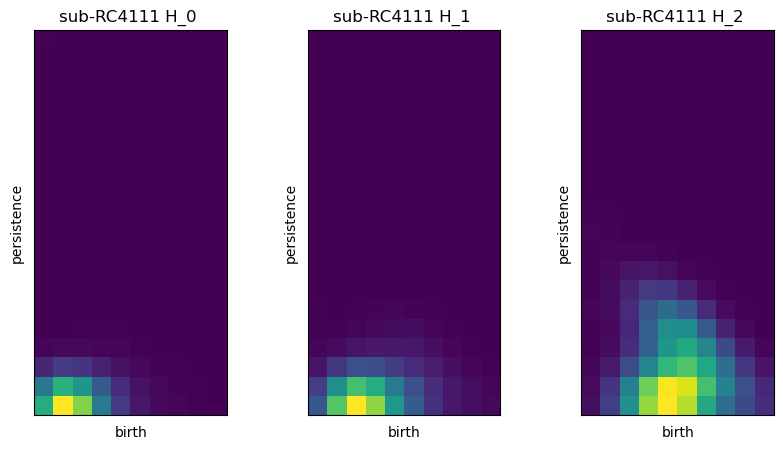

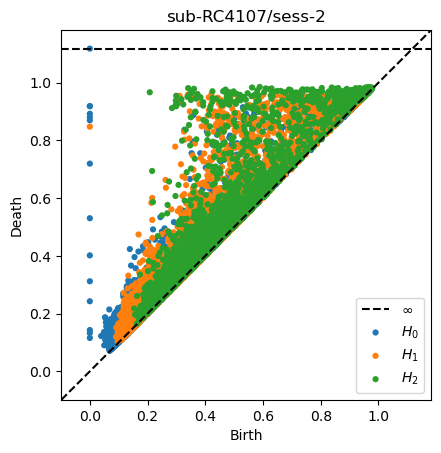

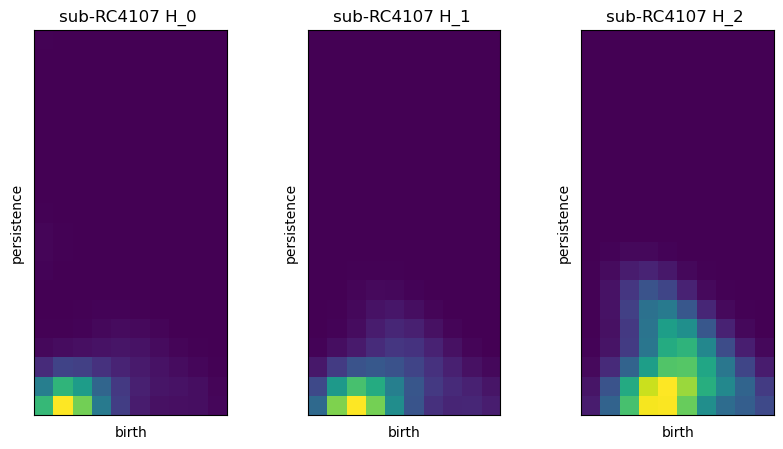

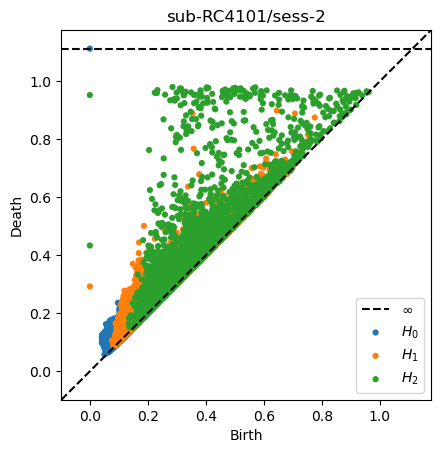

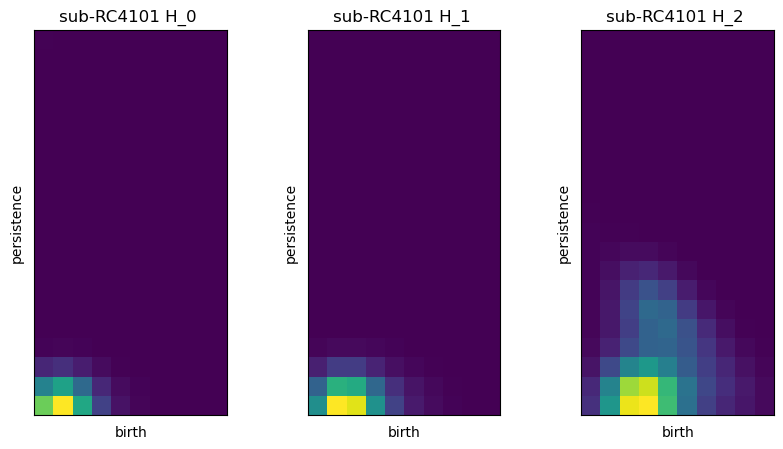

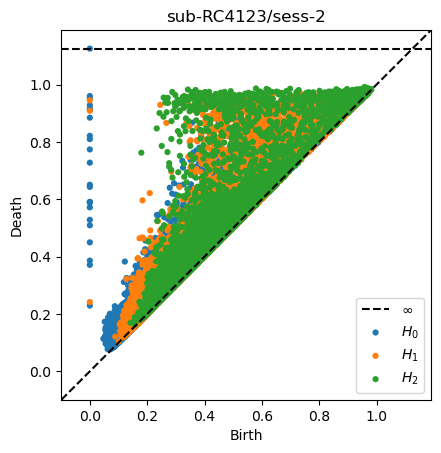

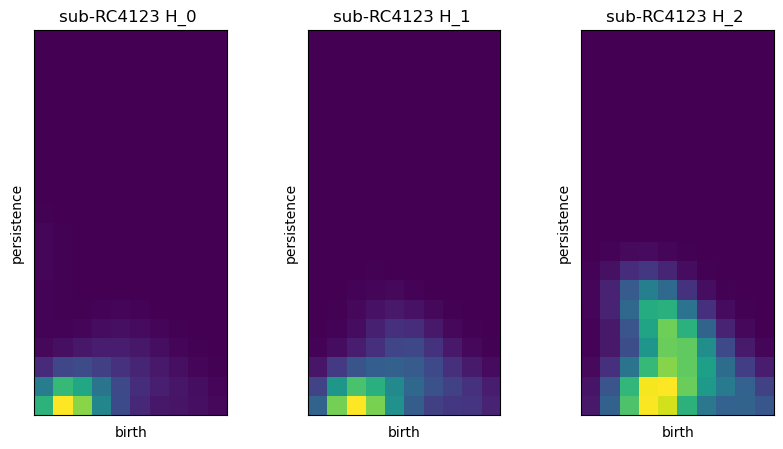

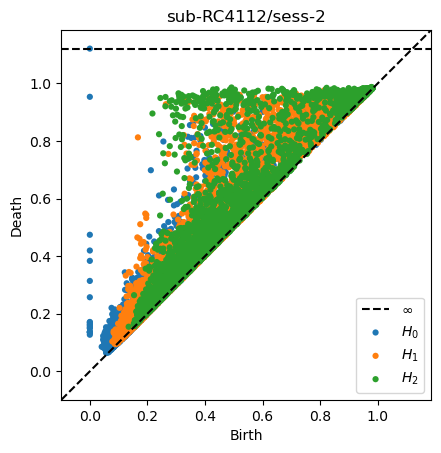

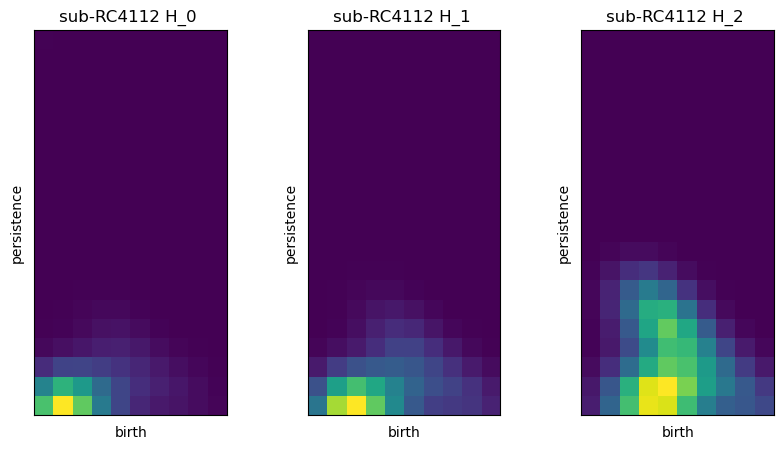

In [21]:
# GFA healthy
import os 
import nibabel as nib
import numpy as np
from dipy.reconst.shm import CsaOdfModel
from dipy.data import get_fnames, default_sphere, get_sphere
# NEW
import matplotlib.pyplot as plt

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from dipy.direction import peaks_from_model
import cripser
import persim

dwi_fname = []
bvec_fname = []
bval_fname =[]
dwi_img=[]
affine =[]
healthy_diagram_array =[]
healthy_pimgs_array=[]
diagrams_H0_healthy = []
diagrams_H1_healthy = []
diagrams_H2_healthy = []
pimgs_H0_healthy = []
pimgs_H1_healthy = []
pimgs_H2_healthy = []
for subject in  listhealthy :
    subj = subject
    sess = '2'
    base_path = f"/home/imane/Documents/openneuro/ds001907/{subj}/ses-{sess}/dwi/"
    dwi_fname.append(base_path+f"{subj}_ses-{sess}_dwi.nii.gz")
    bvec_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bvec")
    bval_fname.append(base_path+f"{subj}_ses-{sess}_dwi.bval")
    dwi_img.append(nib.load(dwi_fname[-1]))
    affine.append(dwi_img[-1].affine)
    bvals, bvecs = read_bvals_bvecs(bval_fname[-1], bvec_fname[-1])
    gtab = gradient_table(bvals, bvecs)
    dwi_data = dwi_img[-1].get_fdata()
    dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)  # Specify the volume index to the b0 volumes
    csamodel = CsaOdfModel(gtab, 4)
    csapeaks = peaks_from_model(model=csamodel,
                            data=dwi_data,
                            sphere=default_sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=dwi_mask,
                            return_odf=False,
                            normalize_peaks=True,
                            parallel= True)

    GFA = csapeaks.gfa
    pd = cripser.computePH(GFA,maxdim=2,location="birth")
    pds = [pd[pd[:,0] == i] for i in range(3)]

    figure, n_axis = plt.subplots()
    n_axis.set_title(subj+"/sess-"+sess)
    diags = [p[:,1:3] for p in pds]
    healthy_diagram_array.append(diags)
    diagrams_H0_healthy.append(sick_diagram_array[-1][0])
    diagrams_H1_healthy.append(sick_diagram_array[-1][1])
    diagrams_H2_healthy.append(sick_diagram_array[-1][2])
    
    
    persim.plot_diagrams(diags,ax=n_axis)
    #tranform pesistance diags to images for each patient
    min_birth, max_death = 0,2
    dclip = [np.clip(d,min_birth, max_death) for d in diags]
    pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
    pimgr.fit(dclip, skew=True)
    pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)
    healthy_pimgs_array.append(pimgs)
    pimgs_H0_healthy.append(pimgs[-1][0])
    pimgs_H1_healthy.append(pimgs[-1][1])
    pimgs_H2_healthy.append(pimgs[-1][2])
    plt.figure(figsize=(10,5))
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        pimgr.plot_image(pimgs[i], ax)
        plt.title(subj+" H_{} ".format(i))
    

In [64]:
sick_diagram_array

[[array([[5.64064849e-002, 6.52607603e-002],
         [6.66255487e-002, 7.16693006e-002],
         [7.41419252e-002, 7.71580259e-002],
         ...,
         [8.68145731e-001, 8.79129072e-001],
         [7.74487554e-001, 8.93579360e-001],
         [0.00000000e+000, 1.79769313e+308]]),
  array([[0.964176  , 0.96799021],
         [0.94717111, 0.95524208],
         [0.94376963, 0.95078777],
         ...,
         [0.08908634, 0.12005901],
         [0.08328943, 0.10604699],
         [0.08225923, 0.13174166]]),
  array([[0.96878085, 0.96973299],
         [0.96562501, 0.97293741],
         [0.96222453, 0.96286559],
         ...,
         [0.16288263, 0.18313539],
         [0.15379543, 0.17587576],
         [0.        , 0.9666318 ]])],
 [array([[7.38508004e-002, 7.57184526e-002],
         [7.83421869e-002, 7.92577946e-002],
         [7.08936800e-002, 7.95380859e-002],
         ...,
         [9.20689781e-001, 9.40537561e-001],
         [8.32939235e-001, 9.41131589e-001],
         [0.00000000e+

In [29]:
pimgs_H0_healthy

[array([8.61922079e-01, 6.72629376e-01, 2.88452826e-01, 1.02715213e-01,
        7.21310796e-02, 1.10618045e-01, 1.58281150e-01, 1.25667758e-01,
        4.61030105e-02, 7.36502920e-03, 4.97583875e-04, 1.38836283e-05,
        1.56429256e-07, 6.97214356e-10, 1.20793261e-12, 7.99907047e-16,
        7.89313331e-19, 7.89313331e-19, 7.89313331e-19, 7.89313331e-19]),
 array([7.10041436e-01, 5.24115958e-01, 2.09962247e-01, 7.82450486e-02,
        6.73702474e-02, 7.74780913e-02, 6.30118798e-02, 3.01425905e-02,
        7.37977007e-03, 8.28091240e-04, 3.95952423e-05, 7.69230712e-07,
        5.88226532e-09, 1.73377989e-11, 1.94312184e-14, 8.53695414e-18,
        1.98756548e-18, 1.98756548e-18, 1.98756548e-18, 1.98756548e-18]),
 array([7.84432880e-01, 6.37621376e-01, 2.89130521e-01, 1.24955183e-01,
        1.06341152e-01, 1.09213114e-01, 8.42962344e-02, 4.07042452e-02,
        1.02643181e-02, 1.17681497e-03, 5.65920491e-05, 1.09111168e-06,
        8.21140578e-09, 2.37186143e-11, 2.60116058e-14, 1.38

Clustering

In [68]:
images_H0 = []
images_H0.extend(pimgs_H0_healthy)
images_H0.extend(pimgs_H0_sick)
diagrams_H0 = []
diagrams_H0.extend(diagrams_H0_healthy)
diagrams_H0.extend(diagrams_H0_sick)

   
images_H0
diagrams_H0 

persistanceimages =[]
persistanceimages.extend(pimgs_H0_healthy)
persistanceimages.extend(pimgs_H0_sick)
persistanceimages.extend(pimgs_H1_healthy)
persistanceimages.extend(pimgs_H1_sick)
persistanceimages.extend(pimgs_H2_healthy)
persistanceimages.extend(pimgs_H2_sick)
persistanceimages

persistencediags = []
persistencediags.extend(sick_diagram_array)
persistencediags.extend(healthy_diagram_array)
persistencediags

[[array([[5.64064849e-002, 6.52607603e-002],
         [6.66255487e-002, 7.16693006e-002],
         [7.41419252e-002, 7.71580259e-002],
         ...,
         [8.68145731e-001, 8.79129072e-001],
         [7.74487554e-001, 8.93579360e-001],
         [0.00000000e+000, 1.79769313e+308]]),
  array([[0.964176  , 0.96799021],
         [0.94717111, 0.95524208],
         [0.94376963, 0.95078777],
         ...,
         [0.08908634, 0.12005901],
         [0.08328943, 0.10604699],
         [0.08225923, 0.13174166]]),
  array([[0.96878085, 0.96973299],
         [0.96562501, 0.97293741],
         [0.96222453, 0.96286559],
         ...,
         [0.16288263, 0.18313539],
         [0.15379543, 0.17587576],
         [0.        , 0.9666318 ]])],
 [array([[7.38508004e-002, 7.57184526e-002],
         [7.83421869e-002, 7.92577946e-002],
         [7.08936800e-002, 7.95380859e-002],
         ...,
         [9.20689781e-001, 9.40537561e-001],
         [8.32939235e-001, 9.41131589e-001],
         [0.00000000e+

In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,pairwise_distances

# Assuming persistence_images is a matrix containing the persistence images
# Compute pairwise distances
distance_matrix = pairwise_distances(persistanceimages, metric='euclidean')

# Determine the number of clusters
# Example: Using silhouette score
max_clusters = 10
best_silhouette_score = -1
best_num_clusters = 2

for num_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(distance_matrix)
    silhouette = silhouette_score(distance_matrix, labels)
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_num_clusters = num_clusters

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_num_clusters)
labels = kmeans.fit_predict(distance_matrix)

# Evaluate and interpret the clusters
# Example: Print the cluster labels
print(labels)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 0 0 0 4 4 0 0 0 0 0 0 0 0 4 0 4 0 0 3 0 1 4 0 4 3 0 0 0 0 4 4
 4 0 4 0 0 0 0 4 4 0 0 0 1 1 1 2 2 4 1 1 1 1 1 1 1 2 4 2 1 2 4 4 2 2 1 2 4
 4 1 1 1 2 2 2 1 2 4 4 1 1 2 2 1 1 1]


In [51]:
import gtda

from gtda.diagrams import PersistenceImage
from sklearn.cluster import KMeans
import numpy as np

# Assuming diagrams_H0 is a list of persistence diagrams



# Convert persistence images to a numpy array
persistence_images = np.array(images_H0)

# Perform clustering using KMeans
n_clusters = 2  # Set the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
cluster_labels = kmeans.fit_predict(persistence_images)

# Print the cluster labels
print("Cluster labels:", cluster_labels)



Cluster labels: [0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 1 0 0 0]


In [ ]:
# imports
from src.pd_pm_kmeans import PD_KMeans, PM_KMeans
from data_utils.pd_pm_methods import *
# Clustering in Persistence Diagram Space
labels= [1,0]
km = PD_KMeans(n_clusters=2, init='kmeans++', random_state=123,numItermax = 100)
pd_preds = km.fit(persistencediags)
print(f'PD ARI score: {adjusted_rand_score(labels, pd_preds)}')


Classification

In [ ]:
## persistence image as a feature extractor and do classification
    pim0 = pimgs_H0_healthy[0]
    pim1 = pimgs_H0_healthy[1]
    pims_h0.append(pim0.ravel()) # vectorise by persistence image
    pims_h1.append(pim1.ravel()) # vectorise by persistence image

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


In [22]:
from skimage import data
n = 100
X = [data.binary_blobs(length=100, blob_size_fraction=0.1).astype(np.float64) for i in range(n)]
X.extend([data.binary_blobs(length=100, blob_size_fraction=0.2) for i in range(n)])
Y = [0 for i in range(n)]
Y.extend([1 for i in range(n)])

In [23]:
len(X)

200

In [24]:
len(Y)

200